# Predicting Collision Cross Section values

Recently, ion mobility–mass spectrometry (IM–MS) has emerged as a promising technique for untargeted metabolomics by providing multi-dimensional separation and high selectivity. Ion mobility can rapidly separate metabolite ions based on their differences in rotationally averaged surface area or collision cross-section (CCS) The collision cross section is defined as the area around a particle in which the center of another particle must be in order for a collision to occur.

In this notebook, we will use a deep learning approach to predict CCS values.

References:
> - [Zhou Z. et al (2020): Ion mobility collision cross-section atlas for known and unknown metabolite annotation in untargeted metabolomics](https://www.nature.com/articles/s41467-020-18171-8)
> - [Chemistry Liretexts: Collisional Cross Section](https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Supplemental_Modules_(Physical_and_Theoretical_Chemistry)/Kinetics/06%3A_Modeling_Reaction_Kinetics/6.01%3A_Collision_Theory/6.1.01%3A_Collisional_Cross_Section#:~:text=The%20collisional%20cross%20section%20is%20defined%20as%20the%20area%20around,molecule%20A's%20collisional%20cross%20section)

In [ ]:
## IPython extension to reload modules before executing user code.
# Autorelad is an IPython extension to reload modules before executing user code.
%load_ext autoreload

# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

In [2]:
!pip install rdkit

In [3]:
import os
import sys

ROOT_DIR = os.sep.join(os.path.abspath('.').split(os.sep)[:-1])
sys.path.insert(0, ROOT_DIR)
DATASET_DIR = "{}/data".format(ROOT_DIR)
print("ROOT_DIR: {}".format(ROOT_DIR))
print("DATASET_DIR: {}".format(DATASET_DIR))

from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re


from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint
from rdkit.Chem.inchi import MolFromInchi
from rdkit.Chem import PandasTools, MolFromSmiles, AllChem, MolFromSmiles, Draw, MolToInchiKey, MolToSmiles
from rdkit import DataStructs
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
from rdkit import RDLogger 
RDLogger.DisableLog('rdApp.*') # switch off RDKit warning messages




from sklearn.preprocessing import StandardScaler, FunctionTransformer, scale

import torch
import torch.nn as nn
import torch.nn.functional as F # contains functional interface of typical operations used for building nn's
import torch.optim as optim     # contains optimizers e.g. Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
# from torchmetrics import ConfusionMatrix, Accuracy
# from tqdm import tqdm
from torch.nn import functional as F

# from lib import utilities
from lib.utilities import *

# import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

torch.set_printoptions(linewidth=120)

import warnings
warnings.filterwarnings("ignore")



ROOT_DIR: /home/jovyan/projects/djoy4stem_github/ccs_prediction
DATASET_DIR: /home/jovyan/projects/djoy4stem_github/ccs_prediction/data


In [4]:
SEED = 1234

# random.seed(SEED)
# np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Data Collection
The data was downloaded from the Unified CCS Compendium website. The entire database was downloaded from the **Compound Table** page as a .csv file, which we will use to train adduct-dependent ccs values.

>- [Unified CCS Compendium](https://mcleanresearchgroup.shinyapps.io/CCS-Compendium/)

The collected data was then cleaned. The CCS values were averaged upon grouping by SMILES and Adduct types. The resuting dataset was saved in the data/folder.

In [5]:
ccs_data = pd.read_csv("{}/ccs_data_cleaned.csv".format(DATASET_DIR))
target   = "CCS_AVG"
smiles_column   = "SMILES"
molecule_column = "RMol"

In [6]:
ccs_data["Ion.Species"].value_counts()

[M+H]            674
[M-H]            658
[M+Na]           564
[M-2H+Na]        105
[M+K]             76
                ... 
[M+17H]            1
[M+18H]            1
[M+19H]            1
[M+20H]            1
[M+H-H2O-NH3]      1
Name: Ion.Species, Length: 65, dtype: int64

The new target columns is now target name appended with *'_AVG'* Let's now remove the duplicates.

In [7]:
if molecule_column in ccs_data.columns:
    ccs_data = ccs_data.drop(molecule_column, axis=1)
ccs_data[molecule_column] = ccs_data[smiles_column].apply(lambda x: MolFromSmiles(x)) 
ccs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478 entries, 0 to 2477
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SMILES           2478 non-null   object 
 1   Ion.Species      2478 non-null   object 
 2   CanonicalSMILES  2478 non-null   object 
 3   CCS              2478 non-null   float64
 4   CCS_AVG          2478 non-null   float64
 5   CCS_stdev        195 non-null    float64
 6   CCS_min          2478 non-null   float64
 7   CCS_max          2478 non-null   float64
 8   CCS_median       2478 non-null   float64
 9   num_samples      2478 non-null   int64  
 10  RMol             2478 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 213.1+ KB


As you can see, the *CCS_stdev* column has only 195 non-null values, because the value is null if there is only one sample in the SMILES-based group.

## Adduct-specific QSPR model fine-tuning
We will focus on the "M+H" adduct type.

In [8]:
ccs_data_m_plus_h = ccs_data[ccs_data["Ion.Species"]=="[M+H]"]
ccs_data_m_plus_h.describe()

,CCS,CCS_AVG,CCS_stdev,CCS_min,CCS_max,CCS_median,num_samples
count,674.000000,674.000000,59.000000,674.000000,674.000000,674.000000,674.000000
mean,206.235935,206.502454,4.962017,206.144540,206.857003,206.505816,1.097923
std,74.468130,74.522534,5.809050,74.436685,74.663096,74.520986,0.330556
min,113.900000,113.900000,0.000000,113.900000,113.900000,113.900000,1.000000
25%,141.900000,141.900000,0.495000,141.900000,141.900000,141.900000,1.000000
50%,186.150000,186.350000,3.253000,186.150000,186.350000,186.350000,1.000000
75%,254.482500,254.482500,7.212500,254.482500,254.577500,254.482500,1.000000
max,439.800000,440.500000,22.802000,439.800000,441.200000,440.500000,3.000000


In [9]:
# ccs_data_m_plus_h[target].plot.hist(alpha=0.5)

In [10]:
ccs_m_plus_h_train, ccs_m_plus_h_val, ccs_m_plus_h_test = min_max_train_validate_test_split_df(ccs_data_m_plus_h, molecule_column, inchikey_column=None, train_valid_ratios=[0.8, 0.10], fp_type= "morgan", random_state=1, return_indices=False)

Computing and storing the InChiKeys...
Splitting the dataset...
539 - 67 - 68
Indices (training):539 - [281, 117]
Indices (validation):67 - [346]
Indices (test):68 - [28]
Train: (539, 12) - Validate: (67, 12) - Test: (68, 12)
Index(['SMILES', 'Ion.Species', 'CanonicalSMILES', 'CCS', 'CCS_AVG',
       'CCS_stdev', 'CCS_min', 'CCS_max', 'CCS_median', 'num_samples', 'RMol',
       'InChIKey'],
      dtype='object')


#### How are the CCS values distributed?
Let's focus on the [M+H] adduct type

(<AxesSubplot:ylabel='Frequency'>,
 <AxesSubplot:ylabel='Frequency'>,
 <AxesSubplot:ylabel='Frequency'>)

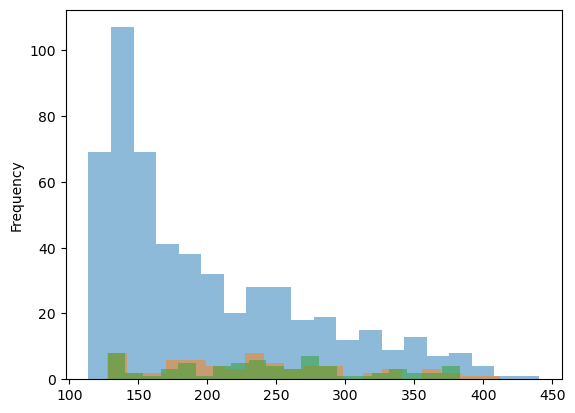

In [11]:
ccs_m_plus_h_train[target].plot.hist(alpha=0.5, bins=20), ccs_m_plus_h_val[target].plot.hist(alpha=0.5, bins=20), ccs_m_plus_h_test[target].plot.hist(alpha=0.5, bins=20)

### Data Augmentation
Similarly to the examples provided by the MolPMoFit authors, we add a Gaussian noise (mean set at 0 and standard deviation σnoise) to the labels of augmented SMILES, in addition to SMILES augmentation.

In [12]:
## Slightly adapted from the original code from https://github.com/XinhaoLi74/MolPMoFiT/blob/master/notebooks/04_QSAR_Regression.ipynb

def ccs_smiles_augmentation(df, N_rounds, smiles_column, target_column, noise = 0.1):
    '''
    noise: add gaussion noise to the label
    '''
    dist_aug = {col_name: [] for col_name in df}
#     print(dist_aug)
    for i in range(df.shape[0]):
        for j in range(N_rounds):
            dist_aug[smiles_column].append(randomize_smiles(df.iloc[i][smiles_column]))
            dist_aug[target_column].append(df.iloc[i][target_column] + np.random.normal(0,noise))
    df_aug = pd.DataFrame.from_dict(dist_aug)
    df_aug = df_aug.append(df, ignore_index=True)
    return df_aug.drop_duplicates(smiles_column)

In [13]:
%%time
ccs_m_plus_h_train_aug = ccs_smiles_augmentation(ccs_m_plus_h_train[[smiles_column, target]], N_rounds=30, smiles_column=smiles_column, target_column=target, noise=0.3)
ccs_m_plus_h_val_aug   = ccs_smiles_augmentation(ccs_m_plus_h_val[[smiles_column, target]], N_rounds=5, smiles_column=smiles_column, target_column=target, noise=0)

ccs_m_plus_h_train_aug.shape, ccs_m_plus_h_val_aug.shape

CPU times: user 10.1 s, sys: 0 ns, total: 10.1 s
Wall time: 10.1 s


((14639, 2), (399, 2))

In [14]:
result_path = Path('{}/results'.format(DATASET_DIR))
path = result_path/target
Model_path = path/'models'

In [15]:
## Building a databunch for QSAR Modeling

bs = 256
tok = Tokenizer(partial(MolTokenizer, special_tokens = special_tokens), n_cpus=2, pre_rules=[], post_rules=[])

qspr_vocab = TextLMDataBunch.from_df(path, ccs_m_plus_h_train_aug, ccs_m_plus_h_val_aug, bs=bs, tokenizer=tok, 
                              chunksize=50000, text_cols=0,label_cols=1, max_vocab=6000, include_bos=False)
print(f'Vocab Size: {len(qspr_vocab.vocab.itos)}')

Vocab Size: 48


Let's create a databunch for our QSPR task.

In [16]:
ccs_databunch = TextClasDataBunch.from_df(path, ccs_m_plus_h_train_aug, ccs_m_plus_h_val_aug, bs=bs, tokenizer=tok, 
                                          chunksize=50000, text_cols=smiles_column,label_cols=target, 
                                          vocab=qspr_vocab.vocab, max_vocab=6000, include_bos=False)

#### Freezing and unfreesing layers

In other words, for example, freeze_to(1) is to freeze layer group 0 and unfreeze the rest layer groups, and freeze_to(3) is to freeze layer groups 0, 1, and 2 but unfreeze the rest layer groups (if there are more layer groups left).

Both freeze and unfreeze sources are defined using freeze_to:

> - When we say freeze, we mean that in the specified layer groups the requires_grad of all layers with weights (except BatchNorm layers) are set False, so the layer weights won't be updated during training.
> - when we say unfreeze, we mean that in the specified layer groups the requires_grad of all layers with weights (except BatchNorm layers) are set True, so the layer weights will be updated during training.

Reference:
> - https://www.kaggle.com/code/danielliao/understanding-learner-freeze-to/notebook

### Fine-tuning

In [32]:
## Here we adapt the Encoder of MSPM According to the Target Dataset.
ccs_values_learner = text_classifier_learner(ccs_databunch, AWD_LSTM, pretrained=False, drop_mult=0.3, metrics = [r2_score, root_mean_squared_error])
ccs_values_learner.load_encoder(f'{target}_MSPM_finetuned_enc') ## Here, we use the MSPM model that we trained earlier.
ccs_values_learner.freeze()
# ccs_values_learner

In [ ]:
max_lr = 0.1
# ccs_values_learner.fit_one_cycle(25, 25e-2, moms=(0.8,0.7))
ccs_values_learner.fit_one_cycle(50, slice(max_lr/25, max_lr), moms=(0.8,0.7))
ccs_values_learner.recorder.plot_lr()

epoch,train_loss,valid_loss,r2_score,root_mean_squared_error,time
0,5026.198730,5936.358887,-0.656990,66.667343,00:16
1,4673.005859,4843.039062,-0.382839,61.689838,00:18
2,4904.686035,5836.095703,-0.629491,66.127769,00:15
3,5071.336914,4925.573730,-0.435625,63.226021,00:17
4,4784.128418,4553.972656,-0.311937,60.268665,00:19
5,4556.998047,4256.265137,-0.209175,57.564735,00:18
6,5211.152344,4680.816406,-0.365393,61.670006,00:17
7,4573.721191,4044.078369,-0.256845,59.329720,00:20
8,5354.518555,6699.683594,-0.908971,72.421120,00:16
9,4974.885254,4894.277344,-0.433962,63.249874,00:19


In [ ]:
ccs_values_learner.fit_one_cycle(25, 3e-2, moms=(0.9,0.8))

In [ ]:
ccs_values_learner.freeze_to(-2)

##   1) Understanding fit_one_cycle: https://iconof.com/1cycle-learning-rate-policy/
##   2) Why I use Fastai and you should too.: https://towardsdatascience.com/why-i-use-fastai-and-you-should-too-a421f6c99508
ccs_values_learner.fit_one_cycle(15, slice(5e-3/(2.6**4),5e-3), moms=(0.9,0.7)) 

In [ ]:
ccs_values_learner.freeze_to(-3)
ccs_values_learner.fit_one_cycle(15, slice(5e-4/(2.6**4),5e-4), moms=(0.8,0.7))

In [ ]:
ccs_values_learner.unfreeze()
ccs_values_learner.fit_one_cycle(20, slice(5e-5/(2.6**4),5e-5), moms=(0.8,0.7))

In [ ]:
ccs_values_learner.save(f'ccs_values_m_plus_h_model')

### Testing the fine-tuned QSPR model

In [ ]:
preds = []

# Randomized SMILES Predictions
for i in range(4):
    np.random.seed(12*i)
    ccs_m_plus_h_test_aug = lm_smiles_augmentation(ccs_m_plus_h_test,1, smiles_column, target_column)
    
    #model
    ccs_databunch_test = TextClasDataBunch.from_df(path, ccs_m_plus_h_train_aug, ccs_m_plus_h_test_aug, tokenizer=tok, vocab=qspr_vocab.vocab,
                                            text_cols=smiles_column, label_cols=target, bs=bs, include_bos=False)
    learner = text_classifier_learner(ccs_databunch_test, AWD_LSTM, pretrained=False, drop_mult=0.2,metrics = [r2_score, root_mean_squared_error])
    learner.load(f'ccs_values_m_plus_h_model'); 
    
    #get predictions
    pred,lbl = learner.get_preds(ordered=True)
    
    preds.append(pred)

# Canonical SMILES Predictions
ccs_databunch_test = TextClasDataBunch.from_df(path, ccs_m_plus_h_train_aug, ccs_m_plus_h_test_aug, bs=bs, tokenizer=tok, 
                              chunksize=5000, text_cols=smiles_column, label_cols=target, vocab=qspr_vocab.vocab, max_vocab=600,
                                              include_bos=False)

learner = text_classifier_learner(ccs_databunch_test, AWD_LSTM, pretrained=False, drop_mult=0.2,metrics = [r2_score, root_mean_squared_error])
learner.load(f'ccs_values_m_plus_h_model');


#get predictions
pred_canonical,lbl = learner.get_preds(ordered=True)
    
preds.append(pred_canonical)


In [ ]:
print('Test Set (Canonical)')
print('RMSE:', root_mean_squared_error(pred_canonical,lbl))
print('R2:', r2_score(pred_canonical,lbl))
print('MAE:', mean_absolute_error(pred_canonical,lbl))

In [ ]:
avg_preds = sum(preds)/len(preds)
print('\n')
print('Test Set (Average)')
print('RMSE:', root_mean_squared_error(avg_preds,lbl))
print('R2:', r2_score(avg_preds,lbl))
print('MAE:', mean_absolute_error(avg_preds,lbl))

In [ ]:
ccs_data.to_csv("{}/ccs_data_cleaned.csv".format(DATASET_DIR))